# Libraries

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import glob
import re
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

2023-07-03 16:38:34.456050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 16:38:35.424850: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-03 16:38:35.424920: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-03 16:38:35.424927: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Helper functions

## F1 Score

In [13]:
# Define helper functions
def f1(y_true, y_pred):
  """
  Function that calculates and returns
  f1_score using Precision and Recall
  """

  def precision(y_true, y_pred):
    """
    Function that calculates and returns precision
    """
    p.update_state(y_true, y_pred)
    return p.result()

  def recall(y_true, y_pred):
    """
    Function that calculates and returns recall
    """
    r.update_state(y_true, y_pred)
    return r.result()

  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)

  return 2 * ((precision*recall) / (precision + recall))

def load_raw_images(img_path):
  '''
  Loads raw images from file paths
  '''
  img_raw = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img_raw)

  return img

## Augmentation

In [14]:
#Define augmentations

def data_augmentation(img_batch):
  def color_aug(img, seed):
    if tf.random.uniform(()) < 0.2:
      img = tf.image.stateless_random_brightness(img, 0.4, seed=seed)
    elif tf.random.uniform(()) < 0.4:
      img = tf.image.stateless_random_contrast(img, 0.5, 2.0, seed=seed)
    elif tf.random.uniform(()) < 0.6:
      img = tf.image.stateless_random_saturation(img, 0.75, 1.25, seed=seed)
    elif tf.random.uniform(()) < 0.8:
      img = tf.image.stateless_random_hue(img, 0.2, seed=seed)
    else:
      img = tf.image.stateless_random_brightness(img, 0.4, seed=seed)
      img = tf.image.stateless_random_contrast(img, 0.5, 2.0, seed=seed)
      img = tf.image.stateless_random_saturation(img, 0.75, 1.25, seed=seed)
      img = tf.image.stateless_random_hue(img, 0.2, seed=seed)

    return img

  def geo_aug(img, seed):
    if tf.random.uniform(()) < 0.5:
      img = tf.image.stateless_random_flip_left_right(img, seed=seed)
      img = tf.image.rot90(img)
      img = tf.image.central_crop(img, central_fraction=0.8)
    else:
      if tf.random.uniform(()) < 0.25:
        img = tf.image.stateless_random_flip_left_right(img, seed=seed)
      if tf.random.uniform(()) < 0.5:
        img = tf.image.rot90(img)
      else:
        img = tf.image.central_crop(img, central_fraction=0.8)

    return img

  def noise_aug(img, seed):
    if tf.random.uniform(()) < 0.2:
      img = tf.image.stateless_random_jpeg_quality(img, 90, 95, seed=seed)
    elif tf.random.uniform(()) < 0.4:
      filter = np.random.choice([3,5,7], 1, p=[0.5,0.25,0.25])[0]
      img = tfa.image.gaussian_filter2d(img, filter_shape=(filter,filter))

    return img

  seed = rng.make_seeds()[:,0]
  batch_aug = []

  for img in img_batch:
    if tf.random.uniform(()) < 0.25:
      img = color_aug(img, seed)
    elif tf.random.uniform(()) < 0.5:
      img = geo_aug(img, seed)
    elif tf.random.uniform(()) < 0.75:
      img = noise_aug(img, seed)
    else:
      img = color_aug(img, seed)
      img = geo_aug(img, seed)
      img = noise_aug(img, seed)

    batch_aug.append(img)

  return batch_aug

## Global Variables

In [15]:
#Define global variables
size = 128
channels = 3
image_size = (size,size)
image_shape = (size,size,channels)
batch_size = 64
buffer_size = 1000

rng = tf.random.Generator.from_seed(42, alg='philox')

# Data prep

## Multi-class data

In [41]:
dir = '/home/alvin/Documents/Masters/CV/dataset'
classes = ['bananas', 'cassava', 'grass', 'jackfruit', 'maize', 'sugarcane']
classes_map = dict(zip(classes,range(len(classes))))
class_dict = {key:len(glob.glob(f'{dir}/{key}/*.jpg')) for key in classes}

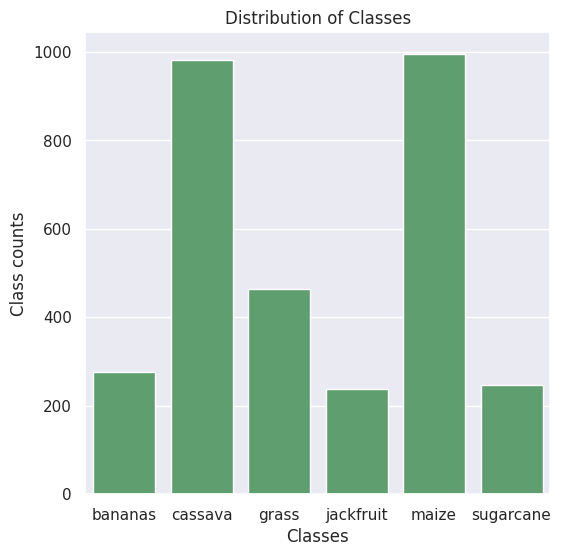

In [4]:
# Plot class distribution

plt.figure(figsize=(6,6))
sns.barplot(y=list(class_dict.values()), x=list(class_dict.keys()), color='g')
plt.title('Distribution of Classes')
plt.ylabel('Class counts')
plt.xlabel('Classes')
plt.show()

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = tf.keras.utils.image_dataset_from_directory(dir,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=42,
                                                       image_size=image_size,
                                                       batch_size=batch_size,
                                                       label_mode='categorical',
                                                       labels='inferred'
                                                       )

val_ds = tf.keras.utils.image_dataset_from_directory(dir,
                                                     validation_split=0.2,
                                                     subset="validation",
                                                     seed=42,
                                                     image_size=image_size,
                                                     batch_size=batch_size,
                                                     label_mode='categorical',
                                                     labels='inferred'
                                                     )

Found 3202 files belonging to 6 classes.
Using 2562 files for training.
Found 3202 files belonging to 6 classes.
Using 640 files for validation.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

['bananas', 'cassava', 'grass', 'jackfruit', 'maize', 'sugarcane']
6


In [7]:
# train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [8]:
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Models

## Single-output models

In [ ]:
# Instantiate precision and recall metric objects
p = Precision()
r = Recall()

# Insantiate early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_auc',
                                        patience=7,
                                        mode='max',
                                        restore_best_weights=True
                                        )

In [ ]:
# Instantiate base model
pre_trained_model = ResNet50(input_shape=(image_shape),
                             include_top = False,
                             weights = 'imagenet',
                             )

# Freeze layers
for layer in pre_trained_model.layers:
  layer.trainable = False

# Add pooling, dropout and dense layers
output = pre_trained_model.output
output = layers.GlobalAveragePooling2D()(output)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dropout(0.2)(output)
output = layers.Dense(num_classes, activation='softmax')(output)

# Create model
model = Model(pre_trained_model.input, output)

# Compile model with custom loss and metric
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[f1, tf.keras.metrics.AUC(name='auc')]
              )

# model.summary()
# tf.keras.utils.plot_model(model)

# Train model
model.fit(train_ds,
          validation_data=val_ds,
          epochs=300,
          callbacks=[early_stopping_callback],
          )

Epoch 1/300
41/41 [==============================] - 12s 148ms/step - loss: 1.6536 - f1: nan - auc: 0.6834 - val_loss: 1.5737 - val_f1: 0.0128 - val_auc: 0.7531
Epoch 2/300
41/41 [==============================] - 2s 56ms/step - loss: 1.5731 - f1: 0.0171 - auc: 0.7214 - val_loss: 1.5351 - val_f1: 0.0202 - val_auc: 0.7638
Epoch 3/300
41/41 [==============================] - 2s 56ms/step - loss: 1.5436 - f1: 0.0270 - auc: 0.7363 - val_loss: 1.5015 - val_f1: 0.0310 - val_auc: 0.7730
Epoch 4/300
41/41 [==============================] - 2s 56ms/step - loss: 1.5106 - f1: 0.0383 - auc: 0.7500 - val_loss: 1.4700 - val_f1: 0.0430 - val_auc: 0.7826
Epoch 5/300
41/41 [==============================] - 2s 56ms/step - loss: 1.4714 - f1: 0.0519 - auc: 0.7678 - val_loss: 1.4407 - val_f1: 0.0572 - val_auc: 0.7949
Epoch 6/300
41/41 [==============================] - 2s 56ms/step - loss: 1.4580 - f1: 0.0638 - auc: 0.7731 - val_loss: 1.4133 - val_f1: 0.0687 - val_auc: 0.8073
Epoch 7/300
41/41 [==========

# Evaluation

## Multi-class evaluation

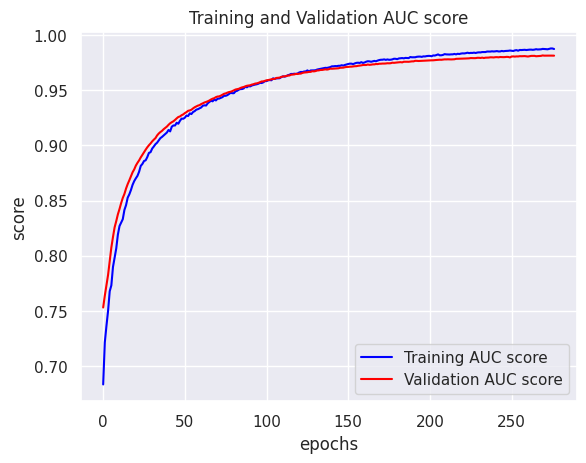

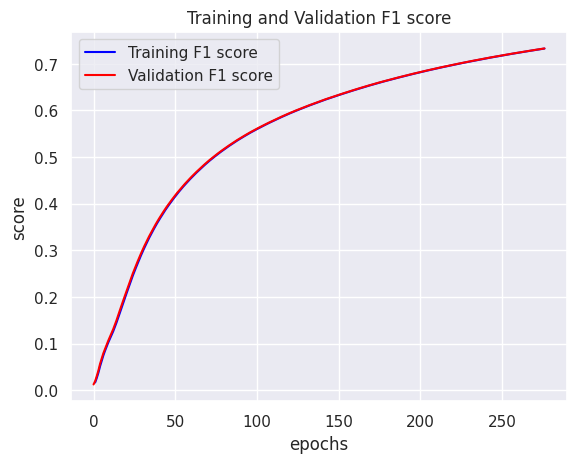

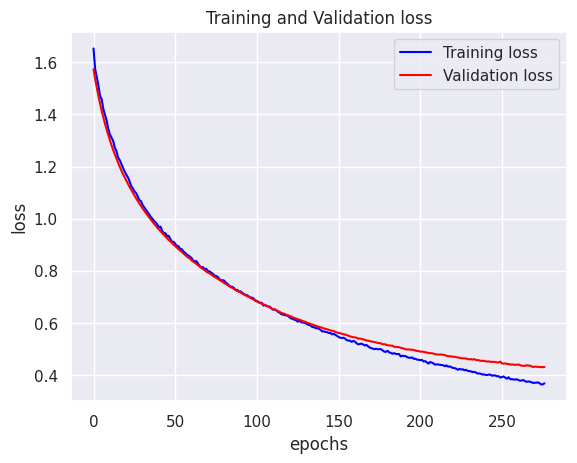

In [ ]:
loss =  model.history.history['loss']
val_loss = model.history.history['val_loss']
f1_score = model.history.history['f1']
val_f1_score = model.history.history['val_f1']
auc_score = model.history.history['auc']
val_auc_score = model.history.history['val_auc']

epochs = range(len(loss))

# Plot training and validation auc
plt.plot(epochs, auc_score, color='blue', label='Training AUC score')
plt.plot(epochs, val_auc_score, color='red', label='Validation AUC score')
plt.xlabel('epochs')
plt.ylabel('score')
plt.title('Training and Validation AUC score')
plt.legend()

plt.figure()

# Plot training and validation f1
plt.plot(epochs, f1_score, color='blue', label='Training F1 score')
plt.plot(epochs, val_f1_score, color='red', label='Validation F1 score')
plt.xlabel('epochs')
plt.ylabel('score')
plt.title('Training and Validation F1 score')
plt.legend()

plt.show()

plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, color='blue', label='Training loss')
plt.plot(epochs, val_loss, color='red', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('/home/alvin/Documents/Masters/CV/model1')

INFO:tensorflow:Assets written to: /home/alvin/Documents/Masters/CV/model1/assets


INFO:tensorflow:Assets written to: /home/alvin/Documents/Masters/CV/model1/assets


In [16]:
model = tf.keras.models.load_model('/home/alvin/Documents/Masters/CV/model1', custom_objects={'f1':f1})

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from imblearn.metrics import classification_report_imbalanced

def cm(y_true, y_pred, labels=None):
  '''
  Generates and displays a confusion matrix
  '''
  matrix = confusion_matrix(y_true, y_pred)

  cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)

  plt.figure(figsize=(8,8))
  plt.title(f"Confusion Matrix")
  cm_display.plot(ax=plt.subplot(), colorbar=False)
  plt.show()

In [18]:
# Run inference
y_pred = model.predict(val_ds)
y_pred.shape

10/10 [==============================] - 4s 39ms/step


(640, 6)

In [19]:
def unbatch_validation_images():
  '''
  Gets validation images from batches
  '''
  n_val_examples = y_pred.shape[0]

  #Unbatch validation dataset
  val = val_ds.unbatch()
  val = val.batch(batch_size=n_val_examples)

  val_images = []
  val_labels = []

  #Get validation images and labels
  for image, label in val.take(1):
    val_images = image.numpy()
    val_labels = label.numpy()

  return val_images, val_labels

In [20]:
#Get validation images
val_images, val_labels = unbatch_validation_images()
val_labels.shape

(640, 6)

In [21]:
pred = pd.get_dummies(np.argmax(y_pred, axis=-1)).to_numpy().astype(np.float32)
pred.shape

(640, 6)

In [22]:
eval_df = pd.DataFrame(data={'target': np.argmax(val_labels, axis=-1),
                             'prediction': np.argmax(y_pred, axis=-1)}
                       ).apply(lambda x: pd.Series(([class_names[x[0]], class_names[x[1]]])), axis=1).rename(columns={0:'target', 1:'prediction'})

correct_df = eval_df.where(eval_df.target == eval_df.prediction).dropna()
incorrect_df = eval_df.where(eval_df.target != eval_df.prediction).dropna()

In [23]:
# Evaluate results
print(classification_report(val_labels, pred, target_names=class_names))
print(classification_report_imbalanced(np.argmax(val_labels, axis=-1), np.argmax(pred, axis=-1), target_names=class_names))

              precision    recall  f1-score   support

     bananas       0.83      0.86      0.85        51
     cassava       0.79      0.85      0.82       202
       grass       0.89      0.97      0.93        96
   jackfruit       0.86      0.98      0.91        43
       maize       0.88      0.86      0.87       188
   sugarcane       0.82      0.45      0.58        60

   micro avg       0.84      0.84      0.84       640
   macro avg       0.84      0.83      0.83       640
weighted avg       0.84      0.84      0.84       640
 samples avg       0.84      0.84      0.84       640

                   pre       rec       spe        f1       geo       iba       sup

    bananas       0.83      0.86      0.98      0.85      0.92      0.84        51
    cassava       0.79      0.85      0.90      0.82      0.87      0.76       202
      grass       0.89      0.97      0.98      0.93      0.97      0.95        96
  jackfruit       0.86      0.98      0.99      0.91      0.98      0.

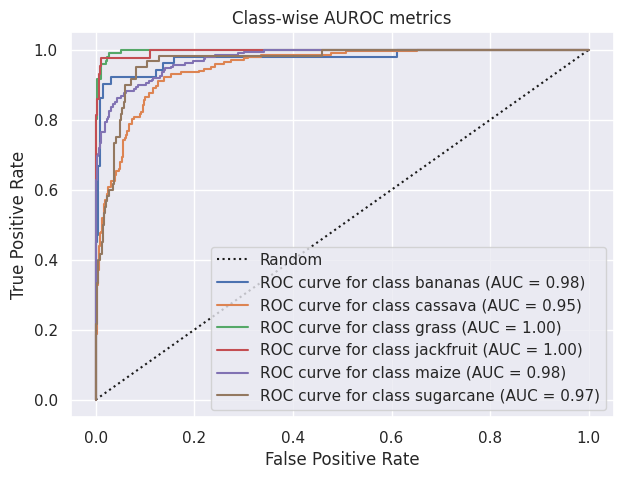

In [24]:
# Evaluate results
plt.figure(figsize=(7,5))
plt.plot([0,1],[0,1],'k:',label='Random')

for label in range(num_classes):
  fpr,tpr,thresholds = roc_curve(val_labels[:,label], y_pred[:,label])
  roc_auc = roc_auc_score(val_labels[:,label], y_pred[:,label])

  # Plot the results
  plt.plot(fpr, tpr, label='ROC curve for class {0} (AUC = {1:0.2f})'.format(class_names[label], roc_auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid()
  plt.legend()
  plt.title(f'Class-wise AUROC metrics')

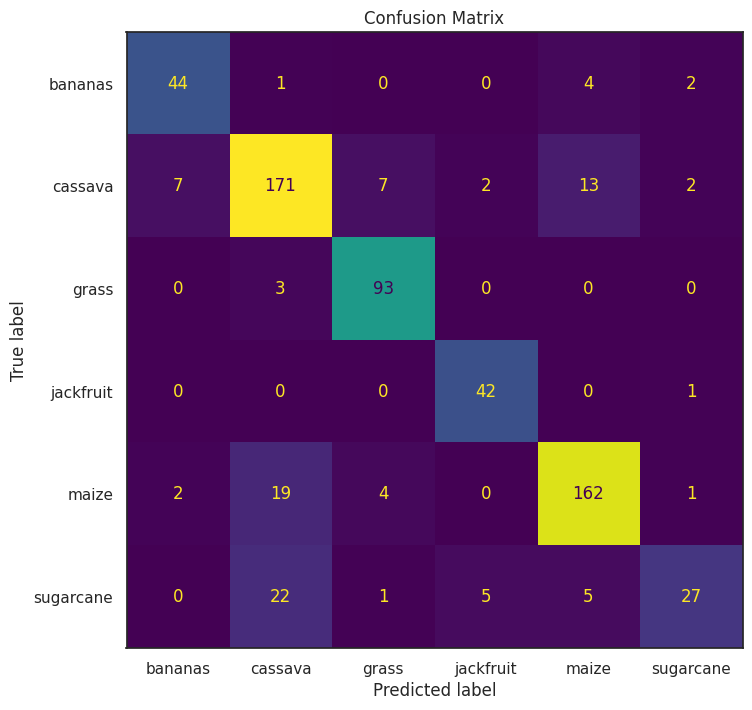

In [25]:
# Plot confusion matrix
sns.set_theme(style="white", palette=None)
cm(np.argmax(val_labels, axis=-1), np.argmax(pred, axis=-1), labels=class_names)

In [26]:
import cv2
import random

def get_saliency_map(img_idx):
  # get the image
  image = val_images[img_idx]

  # add a batch dimension in front
  img = np.expand_dims(image, axis=0)
  expected_output = np.expand_dims(val_labels[img_idx], axis=0)

  with tf.GradientTape() as tape:
      # covert to tensor
      inputs = tf.convert_to_tensor(img, dtype=tf.float32)

      # watch the input pixels
      tape.watch(inputs)

      # generate the predictions
      prediction = model(inputs)

      # get the loss
      loss = tf.keras.losses.categorical_crossentropy(
          expected_output, prediction
      )

  # get the gradient with respect to the inputs
  gradients = tape.gradient(loss, inputs)

  # reduce the RGB image to grayscale
  grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

  # normalize the pixel values to be in the range [0, 255].
  # the max value in the grayscale tensor will be pushed to 255.
  # the min value will be pushed to 0.
  normalized_tensor = tf.cast(
      255
      * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
      / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
      tf.uint8,
  )

  # remove the channel dimension to make the tensor a 2d tensor
  normalized_tensor = tf.squeeze(normalized_tensor)

  gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
  gradient_color = gradient_color / 255.0
  super_imposed = cv2.addWeighted(image, 0.5, gradient_color.astype(np.float32), 0.5, 0.0)

  ax = plt.subplot(2, 4, i+1)
  plt.title(f"Confidence: {np.round(np.max(prediction, axis=-1), 4)}")
  plt.imshow(super_imposed)
  plt.axis('off')

In [27]:
# get model
model = tf.keras.models.load_model('/home/alvin/Documents/Masters/CV/model1', custom_objects={'f1':f1})

In [49]:
idxs = random.choices(correct_df.where(correct_df.target == 'maize').dropna().index.tolist(), k=8)

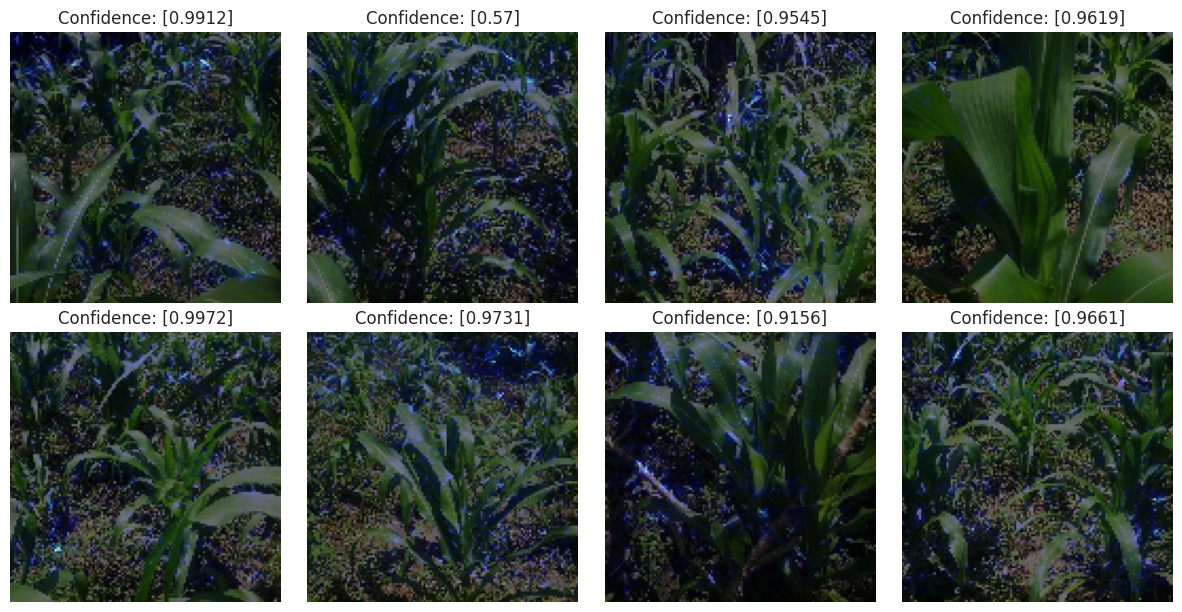

In [50]:
plt.figure(figsize=(15, 15))

for i in range(len(idxs)):
  get_saliency_map(img_idx=idxs[i])

plt.subplots_adjust(hspace=-0.65)
plt.subplots_adjust(wspace=0.1)

In [30]:
import matplotlib.cm as mcm

def make_gradcam_heatmap(img_idx, model, last_conv_layer_name, pred_index=None):
  img_array = tf.convert_to_tensor(np.expand_dims(val_images[img_idx], axis=0), dtype=tf.float32)

  # First, we create a model that maps the input image to the activations
  # of the last conv layer as well as the output predictions
  # Remove last layer's softmax
  model.layers[-1].activation = None
  grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
  )

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    if pred_index is None:
        pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

  # This is the gradient of the output neuron (top predicted or chosen)
  # with regard to the output feature map of the last conv layer
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  # then sum all the channels to obtain the heatmap class activation
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # For visualization purpose, we will also normalize the heatmap between 0 & 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

def display_gradcam(img_idx, alpha=0.002):
    # Prepare image
    img = val_images[img_idx]
    img_tensor = tf.convert_to_tensor(np.expand_dims(val_images[img_idx], axis=0), dtype=tf.float32)

    # Rescale heatmap  and image to a range 0-255
    last_conv_layer_name = 'conv5_block3_out'
    heatmap = make_gradcam_heatmap(img_idx=img_idx, model=grad_model, last_conv_layer_name=last_conv_layer_name)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mcm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.clip_by_value(superimposed_img, 0.0, 1.0)

    # Get the top predicted class is
    preds = model(img_tensor).numpy()
    expected = np.expand_dims(val_labels[img_idx], axis=0)

    ax = plt.subplot(2, 4, i+1)
    plt.title(f"Predicted: {class_names[np.argmax(preds, axis=-1)[0]]}\nExpected: {class_names[np.argmax(expected, axis=-1)[0]]}\nConfidence: {np.round(np.max(preds, axis=-1), 4)}")
    plt.imshow(superimposed_img)
    plt.axis('off')

In [31]:
# get model
grad_model = tf.keras.models.load_model('/home/alvin/Documents/Masters/CV/model1', custom_objects={'f1':f1})

In [55]:
idxs = random.choices(incorrect_df.where(incorrect_df.prediction == 'sugarcane').dropna().index.tolist(), k=8)

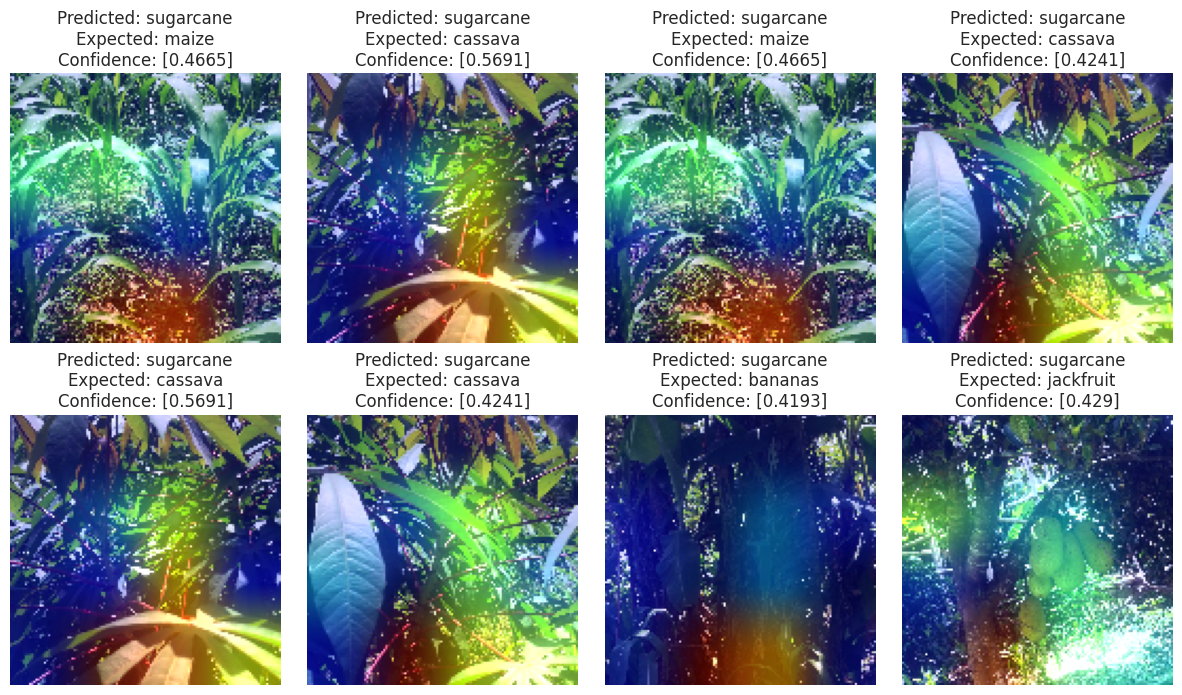

In [56]:
plt.figure(figsize=(15, 15))

for i in range(len(idxs)):
  display_gradcam(img_idx=idxs[i])

plt.subplots_adjust(hspace=-0.58)
plt.subplots_adjust(wspace=0.1)